In [1]:
from skimage.io import imread
import os
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread as gif_imread
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# device = 'cpu'
# print(device)

cuda


In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
PIC_MODES = {'train':10, 'ways':7, 'other':6}
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

batch_size = 4
num_workers = 4

In [4]:
from typing import Callable, List, Tuple

import os
import torch
import catalyst
from catalyst import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")


SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

torch: 1.11.0+cu102, catalyst: 20.12


In [5]:
from pathlib import Path

ROOT = Path('') #"/content/")

train_image_path = ROOT / "train/images"
train_mask_path = ROOT / "train/mask"
test_image_path = ROOT / "test"

In [6]:
ALL_IMAGES = sorted(train_image_path.glob("*.png"))
len(ALL_IMAGES)

8203

In [7]:
ALL_MASKS = sorted(train_mask_path.glob("*.png"))
len(ALL_MASKS)

8203

In [8]:
from typing import List

from torch.utils.data import Dataset

from torch.utils.data import DataLoader
from skimage.transform import resize
import cv2
from PIL import Image
import torchvision.transforms as transforms

In [9]:
class SegmentationDataset(Dataset):
    def __init__(self, pic_mode, images: List[Path], masks: List[Path] = None, transforms = None) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms
        self.pic_mode = pic_mode

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        PIC_MODES = {'train':10, 'ways':7, 'other':6}
        # set up transformation to resize the image
        # resize = transforms.Resize([224, 224])
        to_tensor = transforms.ToTensor()
        result = {}

#         image_path = self.images[idx]
        image = utils.imread(self.images[idx])
#         image = Image.open(image_path)
#         print('image ', type(image), image.shape)
        image = resize(image, (224, 224), mode='constant', anti_aliasing=True)
#         image = resize(image)
        image = to_tensor(image)
#         print('image ', type(image), image.shape)
        
        result["image"] = image
        
        if self.masks is not None:
            mask = utils.imread(self.masks[idx])
#             print('mask ', np.unique(mask))
#             mask[mask > 0] = 255
#             print('mask ', np.unique(mask))
#             mask[mask == PIC_MODES[self.pic_mode]] = 255
#             mask[mask != PIC_MODES[self.pic_mode]] = 0
            mask = np.where(mask == PIC_MODES[self.pic_mode], 255, mask)
            mask = np.where(mask != 255, 0, mask)
#             print('mask ', np.unique(mask))
            mask = resize(mask, (224, 224), mode='constant', anti_aliasing=False)
#             print('mask ', np.unique(mask))
            mask = to_tensor(mask)
            result["mask"] = mask

#         print('image ',result['image'].shape)
#         print('mask ',result['mask'].shape)            

#         if self.transforms is not None:
#             result = self.transforms(**result)
        
#         print('image ',result['image'].shape)
#         print('mask ',result['mask'].shape)         
        
#         print('===========================')
        
#         result["filename"] = image_path.name

        return result

In [10]:
indices = np.arange(len(ALL_IMAGES))

In [11]:
train_indices, valid_indices = train_test_split(indices, 
                                                test_size=0.2, 
                                                random_state=10, 
                                                shuffle=True)

In [12]:
np_images = np.array(ALL_IMAGES)
np_masks = np.array(ALL_MASKS)

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [14]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride = 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride = 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding = 1) ,           
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride = 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride = 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv1 = nn.Sequential(
            nn.Conv2d(512, 512, (1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
        )
        self.bottleneck_pool1 = nn.MaxPool2d(kernel_size=2, stride = 2, return_indices=True)

        self.bottleneck_conv2 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, (1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size = 2, stride = 2) #, indices = self.indices3) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2) #, indices = self.indices2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2) #, indices = self.indices1)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2) #, indices = self.indices0)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size = 3, padding = 1)#,
            #nn.BatchNorm2d(1)
        )

        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # encoder
        #print(x.shape) #torch.Size([25, 3, 256, 256])
        e01 = self.enc_conv0(x)
        #print(e01.shape) #torch.Size([25, 64, 256, 256])
        e02, ind0 = self.pool0(e01)
        #print(e02.shape) #torch.Size([25, 3, 128, 128])
        e11 = self.enc_conv1(e02)
        e12, ind1 = self.pool1(e11)
        e21 = self.enc_conv2(e12)
        e22, ind2 = self.pool2(e21)
        e31 = self.enc_conv3(e22)
        e32, ind3 = self.pool3(e31)

        # bottleneck
        b1 = self.bottleneck_conv1(e32)
        #b2, ind4 = nn.MaxPool2d(b1, kernel_size=2, stride=2,return_indices=True)
        #b3 = nn.MaxUnpool2d(b2, ind4, kernel_size = 2, stride = 2)
        b4 = self.bottleneck_conv2(b1)

        # decoder
        #print(b4.shape) #torch.Size([25, 512, 16, 16])
        d001 = self.upsample0(b4, ind3)
        #print(d001.shape) #torch.Size([25, 512, 32, 32])
        d002 = self.dec_conv0(d001)
        #print(d002.shape) #torch.Size([25, 256, 63, 63])
        d101 = self.upsample1(d002, ind2)
        #print(d101.shape)
        d102 = self.dec_conv1(d101)
        #print(d102.shape)
        d201 = self.upsample2(d102, ind1)
        d202 = self.dec_conv2(d201)
        d301 = self.upsample3(d202, ind0)  # no activation
        d4 = self.dec_conv3(d301)
        return d4 #self.softmax(d4) #nn.Softmax(d4) #, dim = 1) #d4

In [15]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding = 1),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride = 2, padding = 1)  #nn.MaxPool2d(kernel_size=2, stride = 2) #, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding = 1),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=3, stride = 2, padding = 1)   #nn.MaxPool2d(kernel_size=2, stride = 2) #, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding = 1),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=3, stride = 2, padding = 1)   #nn.MaxPool2d(kernel_size=2, stride = 2) #, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding = 1),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=3, stride = 2, padding = 1)   #nn.MaxPool2d(kernel_size=2, stride = 2) #, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv1 = nn.Sequential(
            nn.Conv2d(512, 512, (1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
        )
        self.bottleneck_pool1 = nn.MaxPool2d(kernel_size=2, stride = 2) #, return_indices=True)

        self.bottleneck_conv2 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, (1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels= 512, out_channels =512, kernel_size = 2, stride = 2)   #nn.Upsample(scale_factor=2) #MaxUnpool2d(kernel_size = 2, stride = 2) #, indices = self.indices3) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels= 1024, out_channels =256, kernel_size = 3, padding = 1),
            nn.ConvTranspose2d(in_channels= 256, out_channels =256, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels= 256, out_channels =256, kernel_size = 2, stride = 2)   #nn.Upsample(scale_factor=2) #MaxUnpool2d(kernel_size = 2, stride = 2) #, indices = self.indices2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size = 3, padding = 1),
            nn.ConvTranspose2d(128, 128, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels= 128, out_channels =128, kernel_size = 2, stride = 2)   #nn.Upsample(scale_factor=2) #MaxUnpool2d(kernel_size = 2, stride = 2) #, indices = self.indices1)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size = 3, padding = 1),
            nn.ConvTranspose2d(64, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels= 64, out_channels =64, kernel_size = 2, stride = 2)   #nn.Upsample(scale_factor=2) #MaxUnpool2d(kernel_size = 2, stride = 2) #, indices = self.indices0)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, kernel_size = 3, padding = 1)#,
            #nn.BatchNorm2d(1)
        )


    def forward(self, x):
        # encoder
        e01 = self.enc_conv0(x)
        #print('e01 ', e01.shape)
        e02 = self.pool0(e01)
        #print('e02 ', e02.shape)
        e11 = self.enc_conv1(e02)
        #print('e11 ', e11.shape)
        e12 = self.pool1(e11)
        #print('e12 ', e12.shape)
        e21 = self.enc_conv2(e12)
        #print('e21 ', e21.shape)
        e22 = self.pool2(e21)
        #print('e22 ', e22.shape)
        e31 = self.enc_conv3(e22)
        #print('e31 ', e31.shape)
        e32 = self.pool3(e31)
        #print('e32 ', e32.shape)

        # bottleneck
        b1 = self.bottleneck_conv1(e32)
        #print('b1 ', b1.shape)
        #b2, ind4 = nn.MaxPool2d(b1, kernel_size=2, stride=2,return_indices=True)
        #b3 = nn.MaxUnpool2d(b2, ind4, kernel_size = 2, stride = 2)
        b4 = self.bottleneck_conv2(b1)
        #print('b4 ', b4.shape)

        # decoder
        #print(b4.shape)
        d001 = self.upsample0(b4)
        #print('d001 ', d001.shape)
        d002 = torch.cat([e31, d001], dim = 1)
        #print('d002 ', d002.shape)
        d002 = self.dec_conv0(d002)
        #print('d002 ', d002.shape)
        d101 = self.upsample1(d002)
        #print('d101 ', d101.shape)
        d102 = torch.cat([e21, d101], dim = 1)
        #print('d102 ', d102.shape)
        d102 = self.dec_conv1(d102)
        #print('d102 ', d102.shape)
        d201 = self.upsample2(d102)
        #print('d201 ', d201.shape)
        d202 = torch.cat([e11, d201], dim = 1)
        #print('d202 ', d202.shape)
        d202 = self.dec_conv2(d202)
        #print('d202 ', d202.shape)
        d301 = self.upsample3(d202)  # no activation
        #print('d301 ', d301.shape)
        d302 = torch.cat([e01, d301], dim = 1)
        #print('d302 ', d302.shape)
        d4 = self.dec_conv3(d302)
        #print('d4 ', d4.shape)
        return d4

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
#     print('output: ', outputs.shape)
#     print('labels: ', labels.shape)
#     outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
#     print('after squeeze')
#     print('output: ', outputs.shape)
#     print('labels: ', labels.shape)
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
#     intersection = np.intersect1d(outputs, labels).sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
#     union = np.union(outputs, labels).sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

In [17]:
def bce_loss(y_real, y_pred):
#     print('y_real ', y_real.shape)
#     print('y_pred ', y_pred.shape)
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    loss = torch.FloatTensor().to(device)
    loss = (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

    return torch.mean(loss) #loss

In [18]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    # X_val, Y_val = next(iter(data_val))
    imdict = next(iter(data_val))
    X_val = imdict['image'].float()
    Y_val = imdict['mask']
    
    train_loss, val_loss = [], []
    scores_train, scores_val = [], []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        # for X_batch, Y_batch in data_tr:
        for batch in data_tr:
            X_batch = batch['image'].float()
            Y_batch = batch['mask']
            Y_batch = Y_batch.squeeze(1).byte()
            
            
            # data to device
            inputs = X_batch.to(device)
            labels = Y_batch.to(device)

            # set parameter gradients to zero
            model.zero_grad()
            # forward
            Y_pred = model(inputs)
            loss = loss_fn(labels, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        train_loss.append(avg_loss)
        # show intermediate results
        model.eval()  # testing mode
        
        Y_hat = model(X_val.to(device)).detach().to('cpu')
        
        # detach and put into cpu
        val_loss.append(loss_fn(Y_val.to(device), Y_hat.to(device)))

        scores_train.append(score_model(model, iou_pytorch, data_tr))
        scores_val.append(score_model(model, iou_pytorch, data_val))

        Y_hat = torch.sigmoid(Y_hat).round() #, min = 0.0001, max = 0.9999)
        # Visualize tools
        clear_output(wait=True)
        for k in range(4):
            plt.subplot(3, 4, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 4, k+5)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 4, k+9)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Labels')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return train_loss, val_loss, scores_train, scores_val

In [19]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = model(data).to(device)
    Y_pred = torch.sigmoid(Y_pred).round()
    Y_pred = Y_pred.detach().to('cpu')
    return Y_pred.numpy() #np.array(Y_pred)

In [20]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
#     for X_batch, Y_label in data:
    for batch in data:
        X_batch = batch['image'].float()
        Y_label = batch['mask']
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)
        Y_pred = torch.IntTensor(predict(model, X_batch)).to(device)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

### Обучение на датасете с путями

In [21]:
train_dataset = SegmentationDataset('train',
                                    images = np_images[train_indices].tolist(),
                                    masks = np_masks[train_indices].tolist())

valid_dataset = SegmentationDataset('train',
                                    images = np_images[valid_indices].tolist(),
                                    masks = np_masks[valid_indices].tolist())

data_tr = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

data_val = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

In [22]:
# model_train = SegNet().to(device)
model_train = UNet2().to(device)

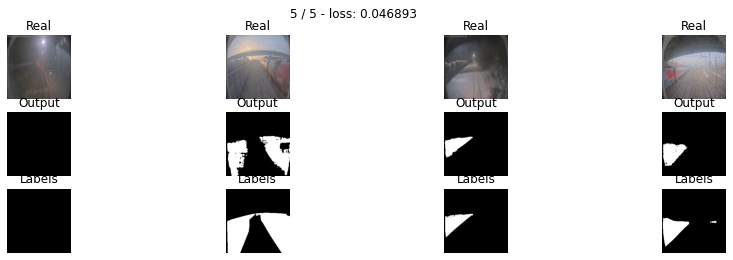

In [25]:
max_epochs = 5
optim = torch.optim.Adam(model_train.parameters(), lr = 0.0001)
model_loss, valid_loss, train_sc, val_sc = train(model_train, optim, bce_loss, max_epochs, data_tr, data_val)

In [26]:
score_model(model_train, iou_pytorch, data_val)

0.8228762380960511

In [27]:
score_model(model_train, iou_pytorch, data_tr)

0.8518941608870901

In [28]:
model_loss = list(x.cpu().detach().numpy() for x in model_loss)
valid_loss = list(x.cpu().detach().numpy() for x in valid_loss)

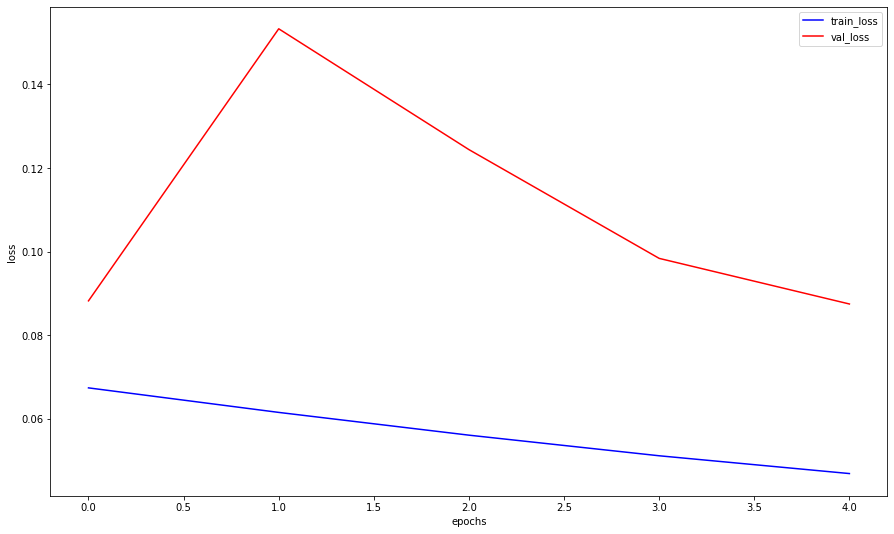

In [29]:
plt.figure(figsize=(15, 9))
plt.plot(model_loss, label="train_loss", color = 'b')
plt.plot(valid_loss, label="val_loss", color = 'r')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

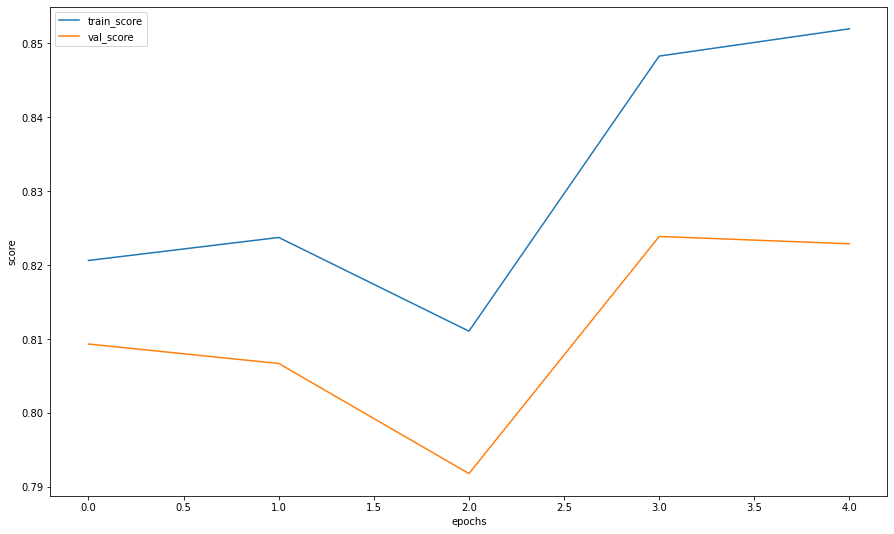

In [30]:
plt.figure(figsize=(15, 9))
plt.plot(train_sc, label="train_score")
plt.plot(val_sc, label="val_score")

plt.xlabel("epochs")
plt.ylabel("score")
plt.legend()
plt.show()

In [31]:
# Сохранить модель
torch.save(model_train.state_dict(), 'model_train.pth')
del model_train

### Обучение на датасете с параллельными путями

In [32]:
model_ways = SegNet().to(device)
model_ways = torch.load('model7.pth')
# model = UNet2().to(device)

In [33]:
train_dataset = SegmentationDataset('ways',
                                    images = np_images[train_indices].tolist(),
                                    masks = np_masks[train_indices].tolist())

valid_dataset = SegmentationDataset('ways',
                                    images = np_images[valid_indices].tolist(),
                                    masks = np_masks[valid_indices].tolist())

data_tr = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

data_val = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

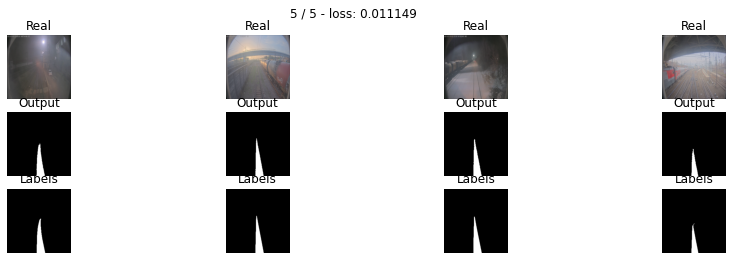

In [34]:
max_epochs = 5
optim = torch.optim.Adam(model_ways.parameters(), lr = 0.0001)
model_loss, valid_loss, train_sc, val_sc = train(model_ways, optim, bce_loss, max_epochs, data_tr, data_val)

In [35]:
score_model(model_ways, iou_pytorch, data_val)

0.95450679063797

In [36]:
score_model(model_ways, iou_pytorch, data_tr)

0.9648072486970483

In [37]:
model_loss = list(x.cpu().detach().numpy() for x in model_loss)
valid_loss = list(x.cpu().detach().numpy() for x in valid_loss)

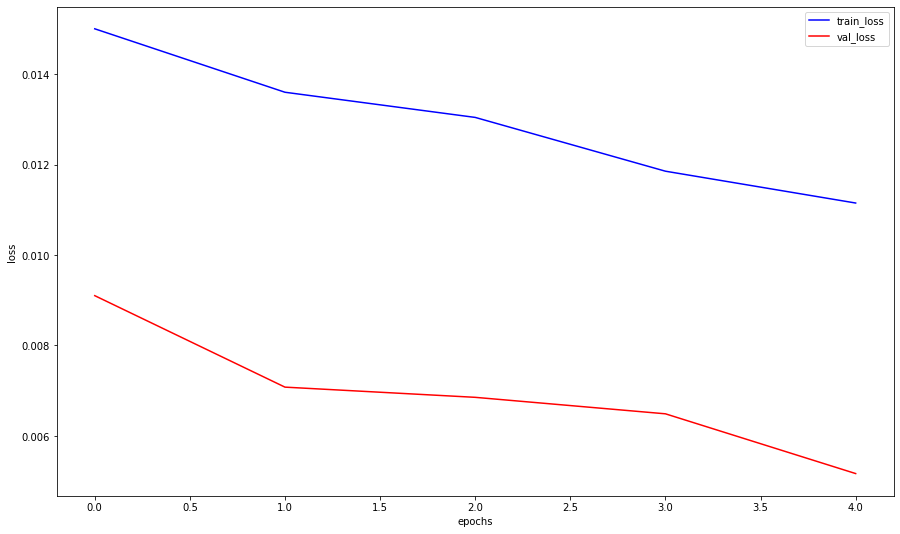

In [38]:
plt.figure(figsize=(15, 9))
plt.plot(model_loss, label="train_loss", color = 'b')
plt.plot(valid_loss, label="val_loss", color = 'r')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

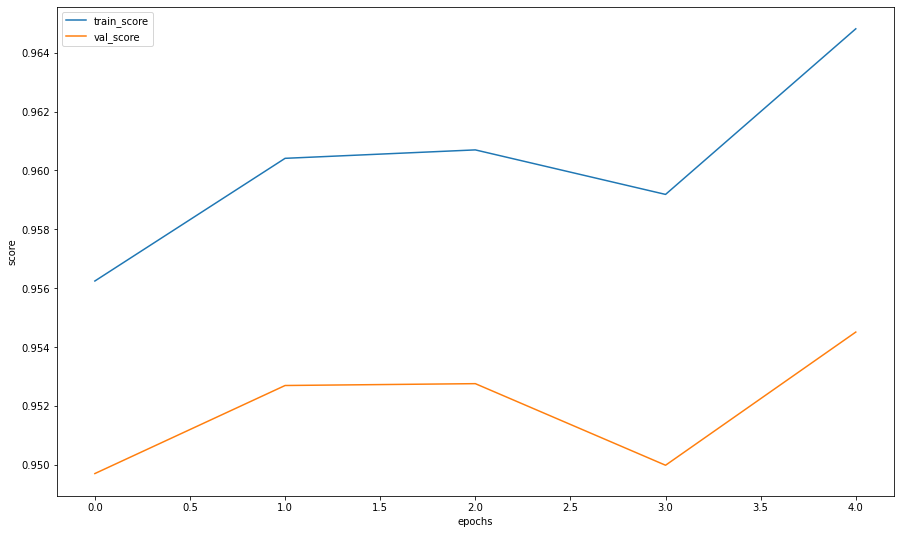

In [39]:
plt.figure(figsize=(15, 9))
plt.plot(train_sc, label="train_score")
plt.plot(val_sc, label="val_score")

plt.xlabel("epochs")
plt.ylabel("score")
plt.legend()
plt.show()

In [40]:
# Сохранить модель
torch.save(model_ways.state_dict(), 'model_ways.pth')
del model_ways

### Обучение на датасете с подвижными составами

In [41]:
model_other = SegNet().to(device)
model_other = torch.load('model6.pth')
# model = UNet2().to(device)

In [42]:
train_dataset = SegmentationDataset('other',
                                    images = np_images[train_indices].tolist(),
                                    masks = np_masks[train_indices].tolist())

valid_dataset = SegmentationDataset('other',
                                    images = np_images[valid_indices].tolist(),
                                    masks = np_masks[valid_indices].tolist())

data_tr = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

data_val = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

In [ ]:
max_epochs = 5
optim = torch.optim.Adam(model_other.parameters(), lr = 0.0001)
model_loss, valid_loss, train_sc, val_sc = train(model_other, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_other, iou_pytorch, data_val)

In [ ]:
score_model(model_other, iou_pytorch, data_tr)

In [ ]:
model_loss = list(x.cpu().detach().numpy() for x in model_loss)
valid_loss = list(x.cpu().detach().numpy() for x in valid_loss)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(model_loss, label="train_loss", color = 'b')
plt.plot(valid_loss, label="val_loss", color = 'r')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_sc, label="train_score")
plt.plot(val_sc, label="val_score")

plt.xlabel("epochs")
plt.ylabel("score")
plt.legend()
plt.show()

In [ ]:
# Сохранить модель
torch.save(model_other.state_dict(), 'model_other.pth')
del model_other

### Инференс

Сделать предсказание каждой моделью и сложить результат + resize к исходному размеру

In [24]:
# Загрузить модели
model_train = SegNet().to(device)
# model_ways = SegNet().to(device)
# model_other = SegNet().to(device)


model_train = torch.load('model10.pth')
# model_ways = torch.load('model7.pth')
# model_other = torch.load('model6.pth')

In [44]:
PIC_MODES = {'train':10, 'ways':7, 'other':6}

In [47]:
def predict_test(path_in, path_out):
    model_train = SegNet().to(device)
    model_ways = SegNet().to(device)
    model_other = SegNet().to(device)


    model_train.load_state_dict(torch.load('model_train.pth'))
    model_ways.load_state_dict(torch.load('model_ways.pth'))
    model_other = torch.load('model6.pth')
    
    test_im = os.listdir(path_in)
    tdir = f'{path_in}/'
    rdir = f'{path_out}/'
    for img in test_im:
        rz = imread(f'{tdir}{img}')
        old_size = (rz.shape[0], rz.shape[1])
        size = (224,224)
        rz = resize(rz, size, mode='constant', anti_aliasing=True)
        rz = [rz]
        rz = np.array(rz, np.float32)
        rz = torch.Tensor(np.rollaxis(rz, 3, 1))
        
        rez_train = predict(model_train, rz.to(device))
        rez_ways = predict(model_ways, rz.to(device))
        rez_other = predict(model_other, rz.to(device))
        
        rez = {'rez_train': rez_train.squeeze(0),
               'rez_ways': rez_ways.squeeze(0),
               'rez_other': rez_other.squeeze(0)}
        
        for rz in rez:
            rez[rz] = cv2.merge((rez[rz][2], rez[rz][1], rez[rz][0]))  # Use opencv to merge as b,g,r
            rez[rz] = resize(rez[rz], old_size, anti_aliasing=True)
            rez[rz] = np.where(rez[rz] > 0.3, PIC_MODES[rz.split('_')[1]], rez[rz])
            rez[rz] = np.where(rez[rz] != PIC_MODES[rz.split('_')[1]], 0, rez[rz])
            rez[rz] = np.int_(rez[rz]) #.as_type(int)
        
        out = rez['rez_other'] + rez['rez_train']
        out = np.where(out > 10, 10, out)
        out += rez['rez_ways']
        out = np.where(out > 10, 6, out)
        cv2.imwrite(f'{rdir}{img}', out)
        print('picture done')

In [ ]:
predict_test('test', 'result')

picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done
picture done

In [52]:
test_im = os.listdir('test')

In [53]:
tdir = 'test/'

In [116]:
tim1 = imread(f'{tdir}{test_im[6]}')
tim1.shape, test_im[6]

((1512, 2688, 3), 'img_0.86412286067481.png')

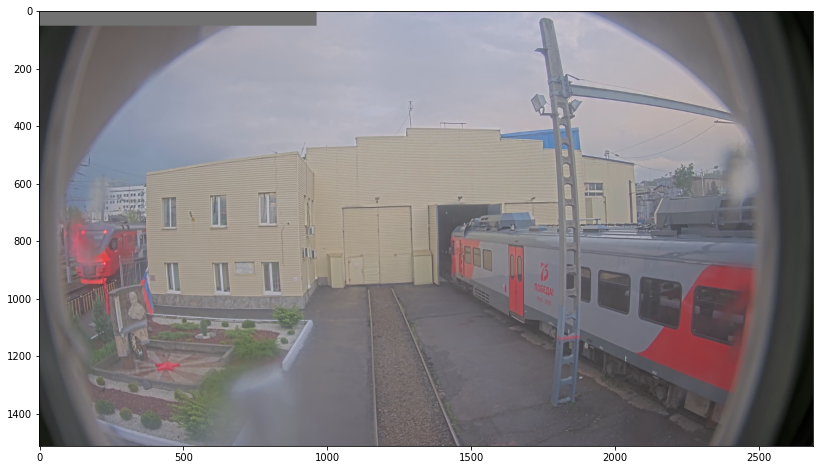

In [117]:
plt.figure(figsize=(15,8))
plt.imshow(tim1)

In [118]:
old_size = (tim1.shape[0], tim1.shape[1])
old_size

(1512, 2688)

In [119]:
size = (RESCALE_SIZE,RESCALE_SIZE)

In [120]:
tim1 = resize(tim1, size, mode='constant', anti_aliasing=True)

In [121]:
tim1.shape

(224, 224, 3)

In [122]:
tim1 = [tim1]

In [123]:
tim1 = np.array(tim1, np.float32)

In [124]:
tim1.shape

(1, 224, 224, 3)

In [125]:
tim1 = torch.Tensor(np.rollaxis(tim1, 3, 1))

In [126]:
tim1.shape

torch.Size([1, 3, 224, 224])

In [143]:
rez_train = predict(model_train, tim1.to(device))
rez_ways = predict(model_ways, tim1.to(device))
rez_other = predict(model_other, tim1.to(device))

In [144]:
# rez_train = rez_train.squeeze(0)
# rez_ways = rez_ways.squeeze(0)
# rez_other = rez_other.squeeze(0)

In [145]:
rez = {'rez_train': rez_train.squeeze(0),
       'rez_ways': rez_ways.squeeze(0),
       'rez_other': rez_other.squeeze(0)}

In [146]:
img_rez = []
for rz in rez:
    rez[rz] = cv2.merge((rez[rz][2], rez[rz][1], rez[rz][0]))  # Use opencv to merge as b,g,r
    print(rez[rz].shape)
    rez[rz] = resize(rez[rz], old_size, anti_aliasing=True)
    rez[rz] = np.where(rez[rz] > 0.6, 255, rez[rz])
    rez[rz] = np.where(rez[rz] != 255, 0, rez[rz])
    rez[rz] = np.int_(rez[rz]) #.as_type(int)
    print(rez[rz].shape)

(224, 224, 3)
(1512, 2688, 3)
(224, 224, 3)
(1512, 2688, 3)
(224, 224, 3)
(1512, 2688, 3)


In [107]:
# for rz in rez:
#     img_result.append(resize(img, old_size, anti_aliasing=True))
#     img_result[-1] = np.where(img_result[-1] > 0.6, 255, img_result[-1])
#     img_result[-1] = np.where(img_result[-1] != 255, 0, img_result[-1])
#     print(img_result[-1].shape)

In [147]:
out = np.round(rez['rez_train'] + rez['rez_other'] + rez['rez_ways'])
out.shape

(1512, 2688, 3)

In [148]:
out = np.where(out > 255, 255, out)

In [110]:
cv2.imwrite('out.png', out)

True

In [ ]:
cv2.imwrite('out.png', result)

In [ ]:
img.sum()

In [150]:
np.unique(out)

array([  0, 255])